# Project 02 - Image segmentation and object detection

__Handout date:__ 23.05.2024  
__Submission deadline:__ 19.06.2024 - 23:59  
__Topics:__ Segmentation and object detection.  
__Submission link:__ https://fz-juelich.sciebo.de/s/410NfCTI5rMLv1n

In this project, we would like you to investigate image segmentation and object detection.
For this, you will use the data from the [Broad Bioimage Benchmark Collection](https://bbbc.broadinstitute.org/BBBC039).
The dataset contains images of cells acquired using fluorescence microscopy, along with annotations of individual cells.
Your goal will be to apply the segmentation and detection methods described in the lecture to the dataset.

__Note:__ The main goal of this project to get you working on a real-world segmentation/detection task. Projects will not be graded based on the performance of the trained classifiers.

![A stack of images](./broad_dataset.png)

We suggest that you follow the following  steps:
1. __Know your data__ Have a look  at the resources provided on the website to understand the dataset.
1. Download and inspect the images, groundtruth annotations, and metadata. Plot a few example datapoints. __Tip:__ The data has fixed URLs, so you can download the data from within the notebook (e.g., using `!wget URL`).
1. Write a data loader that allows you to use the data in PyTorch. Split the data according to the training, test, and validation files provided in the metadata.
1. Train one or multiple of the segmentation models discussed in the lecture (or any other segmentation model you would like to try) to segment the cells. Report the loss curve, appropriate quality metrics, and some example results of the trained model(s). 
1. Train one of multiple of the detection models discussed in the lecture (or any other detection method you would like to try) to detect the cells. Report the loss curve, appropriate quality metrics, and some example results of the trained model(s). 

Tipps and hints:
1. Please do not add the dataset to your submission. Use `.gitignore` to ignore the directory containing the downloaded dataset.
1. Think about how you have to process the provided groundtruth data to make it usable for segmentation and detection.
1. `scikit-image` provides several helpful functions for extracting information from masks. Have a look at `skimage.measure.label` and `skimage.measure.regionprops`. These can help to convert data into a format that is appropriate for detection.

In [2]:
# download the data from Broad Institute
!wget https://data.broadinstitute.org/bbbc/BBBC039/images.zip
!wget https://data.broadinstitute.org/bbbc/BBBC039/metadata.zip
!wget https://data.broadinstitute.org/bbbc/BBBC039/masks.zip
!unzip -q images.zip
!unzip -q metadata.zip
!unzip -q masks.zip
!rm images.zip metadata.zip masks.zip

In [132]:
# import packages

import os
import numpy as np
import pandas as pd
from torchvision.io import read_image
from PIL import Image
import matplotlib.pyplot as plt
import skimage.io
import skimage.morphology
from torch.utils.data import Dataset, DataLoader

In [130]:
## Prepare the input images
img_dir = 'images'
out_dir = 'images_processed'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

for img_name in os.listdir(img_dir):
    img_path = os.path.join(img_dir, img_name)
    out_path = os.path.join(out_dir, img_name.split('.')[0] + '.png')
    img = skimage.io.imread(img_path)
    img = skimage.exposure.rescale_intensity(img, out_range=(0, 255))
    skimage.io.imsave(out_path, img.astype(np.uint8))

## Prepare the 3-class masks
def create_mask(img_path, out_path):
    img = skimage.io.imread(img_path)

    # the mask is the first channel of the image
    img = img[:, :, 0]

    # threshold the image
    img = skimage.morphology.label(img)
    img = skimage.morphology.remove_small_objects(img)
    img = skimage.morphology.binary_erosion(img)
    boundaries = skimage.segmentation.find_boundaries(img)
    label_binary = np.zeros((img.shape + (3,)))

    # create the 3-class(channels) mask
    label_binary[(img == 0) & (boundaries == 0), 0] = 1
    label_binary[(img != 0) & (boundaries == 0), 1] = 1
    label_binary[boundaries == 1, 2] = 1
    # save the mask
    skimage.io.imsave(out_path, label_binary.astype(np.uint8) * 255)

# create the mask for each image
img_dir = 'masks'
mask_dir = 'masks_processed'

if not os.path.exists(mask_dir):
    os.makedirs(mask_dir)

for img_name in os.listdir(img_dir):
    img_path = os.path.join(img_dir, img_name)
    out_path = os.path.join(mask_dir, img_name)
    create_mask(img_path, out_path)

/tmp/ipykernel_3656/302769877.py:34: UserWarning: masks_processed/IXMtest_P23_s7_w13B627CB9-6C57-4049-AAD7-6468A051DD24.png is a low contrast image
  skimage.io.imsave(out_path, label_binary.astype(np.uint8) * 255)
/tmp/ipykernel_3656/302769877.py:34: UserWarning: masks_processed/IXMtest_F12_s8_w1DBD80811-5297-4415-ACD1-EC9286BE76A4.png is a low contrast image
  skimage.io.imsave(out_path, label_binary.astype(np.uint8) * 255)
/tmp/ipykernel_3656/302769877.py:34: UserWarning: masks_processed/IXMtest_L10_s6_w12D12D64C-2639-4CA8-9BB4-99F92C9B7068.png is a low contrast image
  skimage.io.imsave(out_path, label_binary.astype(np.uint8) * 255)
/tmp/ipykernel_3656/302769877.py:34: UserWarning: masks_processed/IXMtest_L01_s2_w1E5038251-DBA3-44D0-BC37-E43E2FC8C174.png is a low contrast image
  skimage.io.imsave(out_path, label_binary.astype(np.uint8) * 255)
/tmp/ipykernel_3656/302769877.py:34: UserWarning: masks_processed/IXMtest_F13_s7_w13C1B1D8C-293E-454F-B0FD-6C2C3F9F5173.png is a low contras

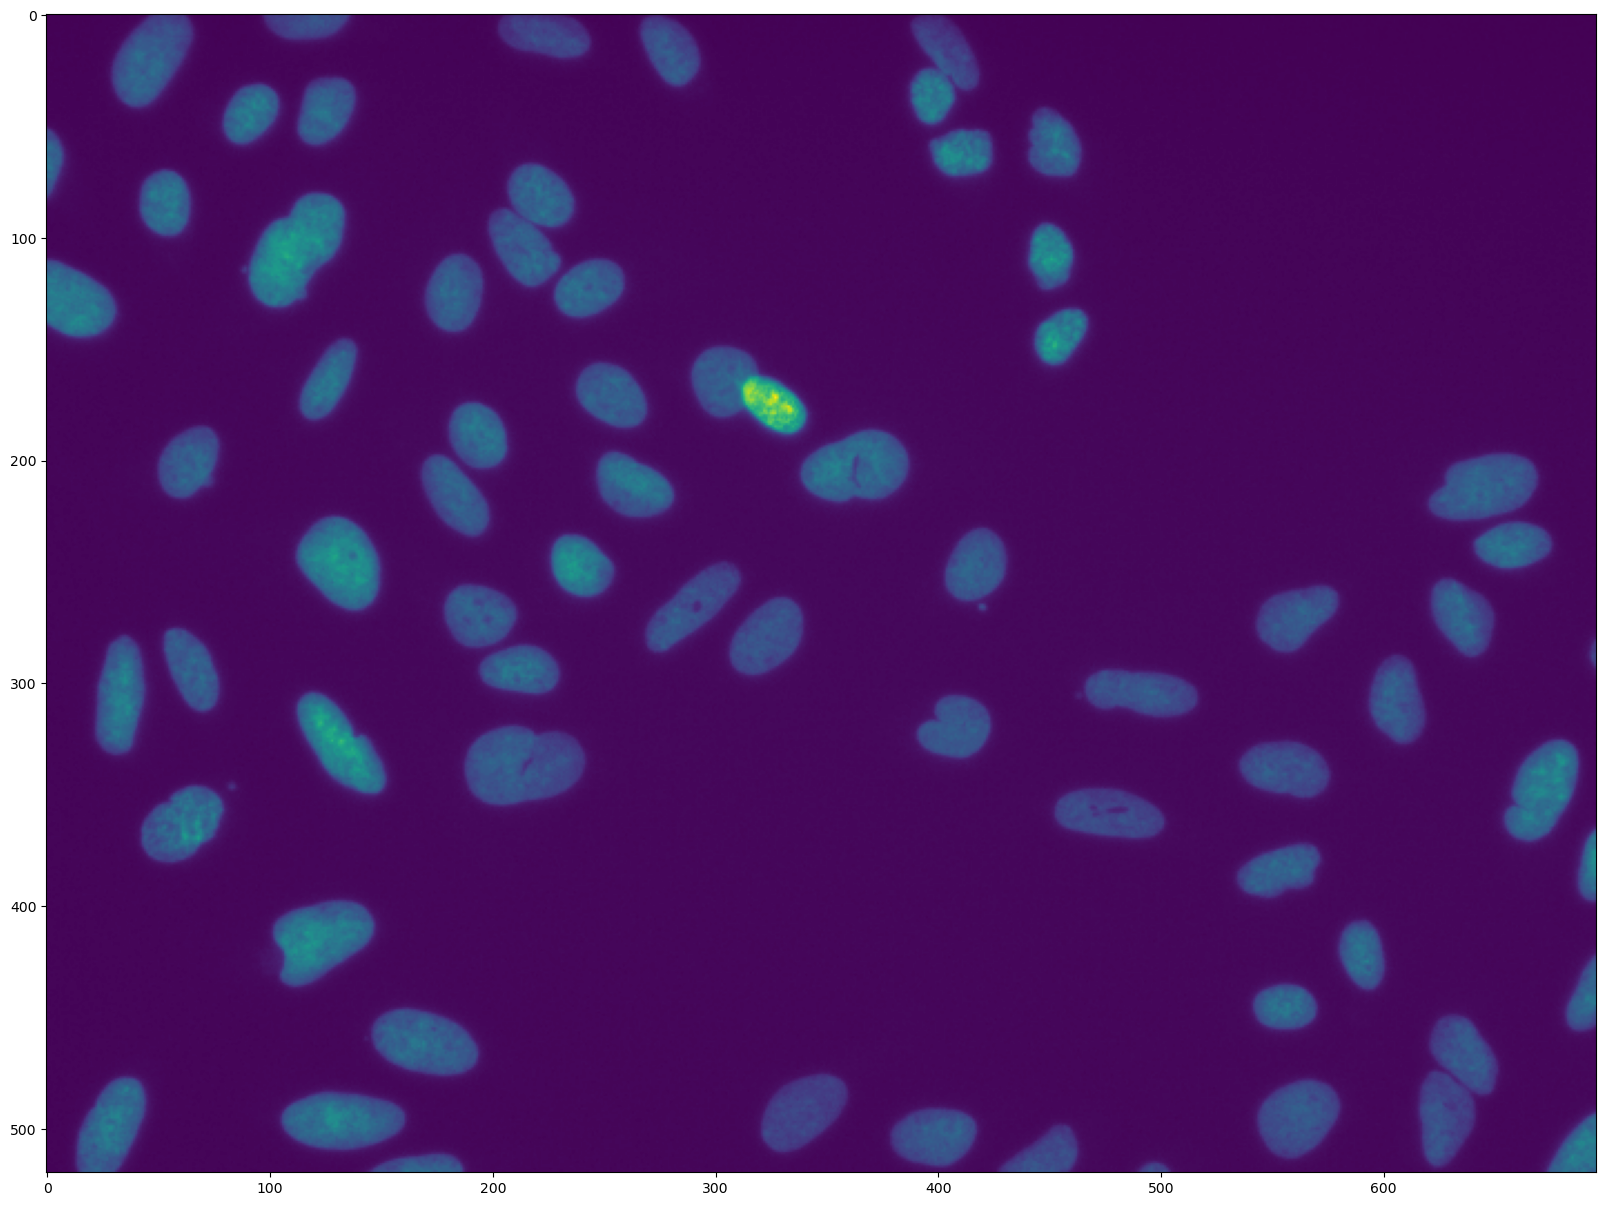

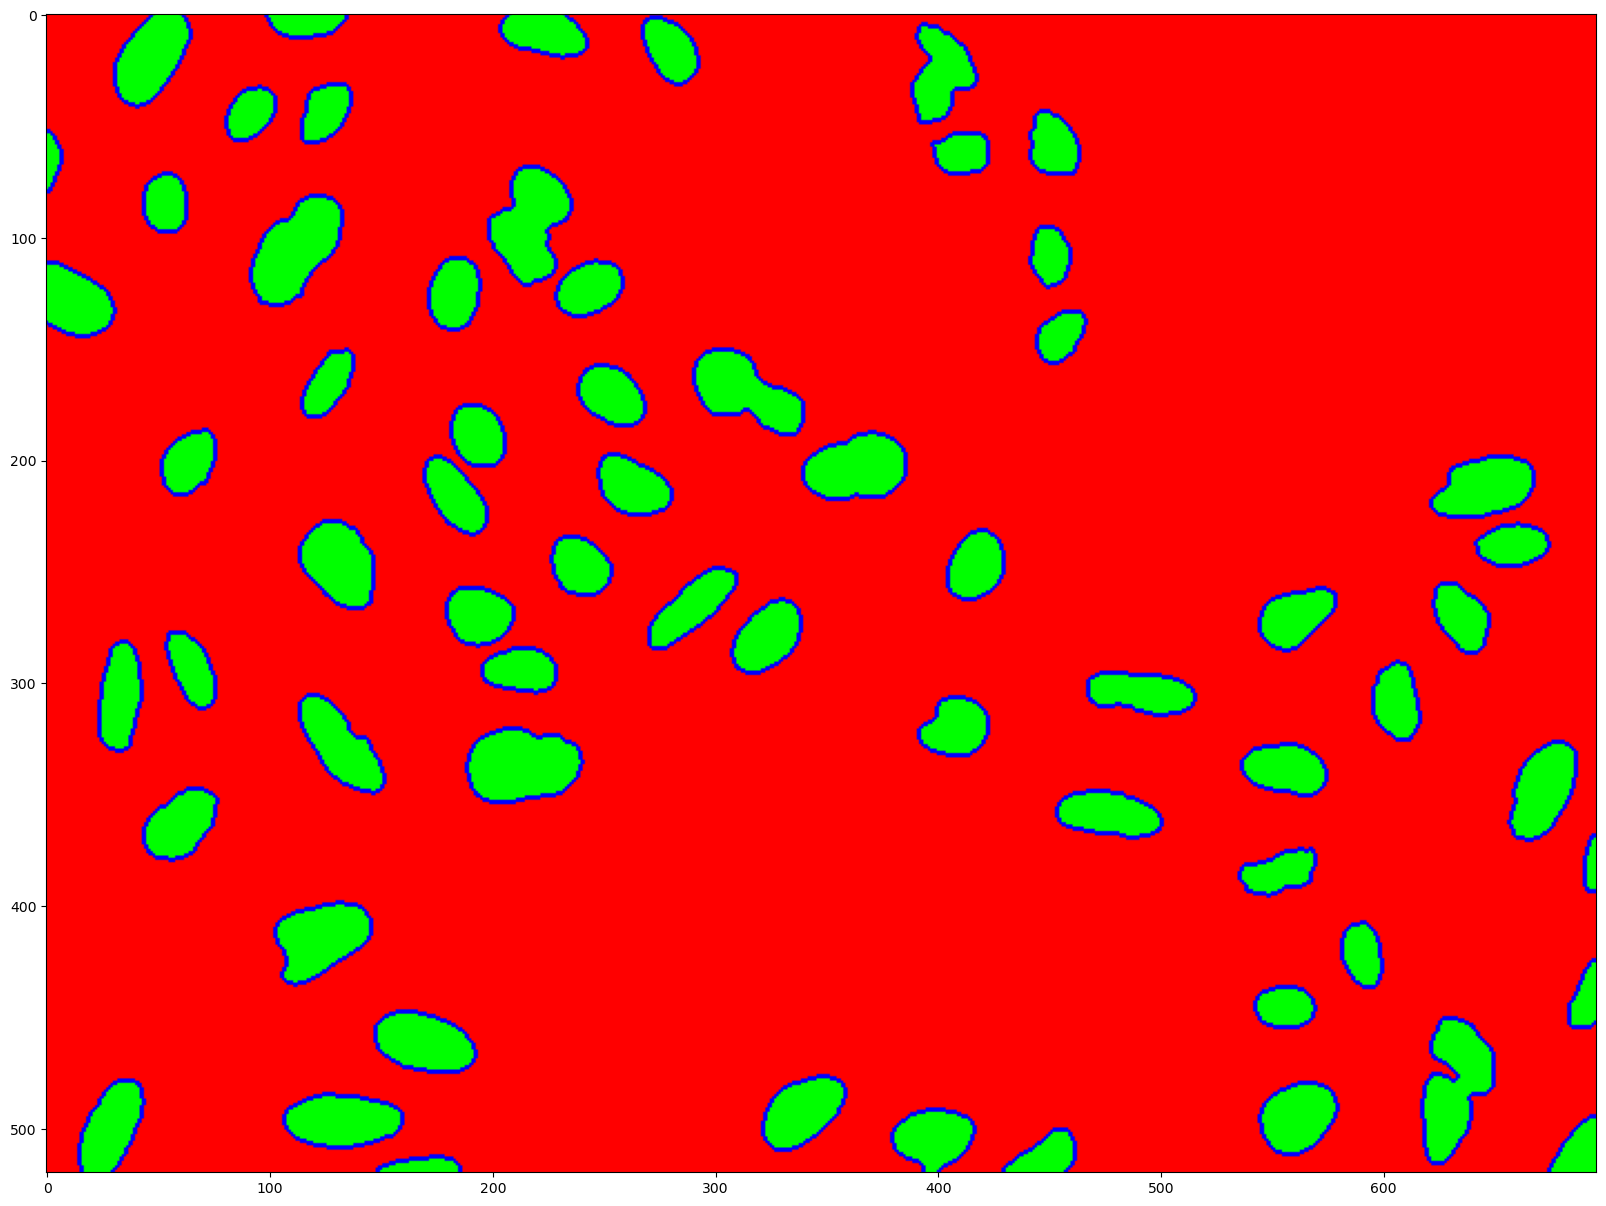

In [135]:
## create a dataloader using pytorch
class nucleiDataset(Dataset):
    def __init__(self, image_dir, mask_dir, metadata_file, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.metadata = pd.read_csv(metadata_file)
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.metadata.iloc[idx, 0])
        mask_name = os.path.join(self.mask_dir, self.metadata.iloc[idx, 0])
        image = read_image(img_name)
        mask = read_image(mask_name)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

# create the total dataset
dataset = nucleiDataset(image_dir='./images_processed', mask_dir='./masks_processed'
    , metadata_file='metadata/filenames_and_plates.csv')

# show the first image and mask
image, mask = next(iter(dataset))
plt.imshow(image.permute(1, 2, 0))
plt.show()
plt.imshow(mask.permute(1, 2, 0))
plt.show()


# split the dataset into train and test
train_dataset = nucleiDataset(image_dir='./images_processed', mask_dir='./masks_processed'
    , metadata_file='./metadata/training.txt')
train_dl = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataset = nucleiDataset(image_dir='./images_processed', mask_dir='./masks_processed'
    , metadata_file='./metadata/validation.txt')
val_dl = DataLoader(val_dataset, batch_size=4, shuffle=True)
test_dataset = nucleiDataset(image_dir='./images_processed', mask_dir='./masks_processed'
    , metadata_file='./metadata/test.txt')
test_dl = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [ ]:
## Use U-Net to segment the nuclei
import torch
import torch.nn as nn
